<a href="https://colab.research.google.com/github/mifm/examples/blob/master/bsc_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openturns

In [ ]:
!pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/basic-plugins/support-structure-mass-surrogate.git

In [3]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

from ssms.models import model_path
from ssms.load_QLS import QLSModel, get_r2

In [21]:
surrogate_path = os.path.join(model_path, 'QLS')
path = os.path.join(surrogate_path, '15.0_QLS_surrogate_model.pickle')
with open(path, 'rb') as f:
    dic = pickle.load(f)
input_channel_names = dic['input_channel_names']
output_channel_names = dic['output_channel_names']
out_item = 2
output_channel = output_channel_names[out_item]
print(f'output channel: {output_channel}')
df = dic['df']
qlsm = QLSModel(dic['models'][out_item], dic['input_scaler'], dic['output_scalers'][output_channel])

output channel: total_mass


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


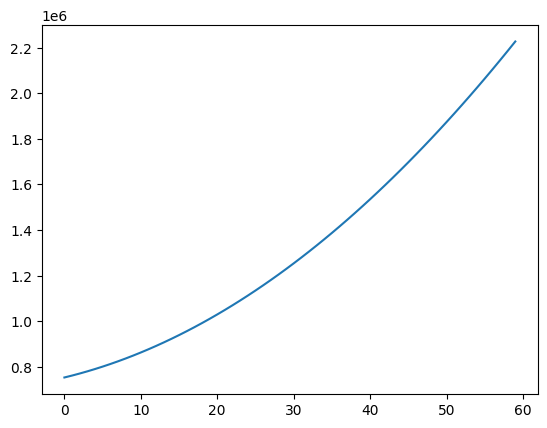

In [25]:
res = qlsm.predict(RP=60*[10], D=60*[200], HTrans=60*[12], HHub_Ratio=60*[0.7], WaterDepth=np.arange(0,60), WaveHeight=60*[3.5], WavePeriod=60*[6], WindSpeed=60*[9])
plt.figure()
plt.plot(np.arange(0,60), res)